In [1]:
import pandas as pd
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import numpy as np
import random
import math  # 导入数学运算库
from sklearn.preprocessing import MinMaxScaler

## 读取数据集

In [2]:
data = pd.read_csv("C:/Users/Administrator/Desktop/毕设/旅游景点数据集/新数据集.csv", encoding='utf-8')

## 提取部分数据集测试

In [3]:
city_value = '上海'
# 使用条件切片选择符合条件的行
data = data[data["城市"] == city_value]

data.reset_index(drop=True, inplace=True)
data['编号'] = range(len(data))  # 将编号列的值进行重新编号，确保第一列能将景点按顺序排序

## 函数定义

In [4]:
# 计算景点之间的距离
def calculate_distance(point1,point2):
    info_1 = data.loc[point1]  # 获取对应行的数据
    info_2 = data.loc[point2]
    origin = (info_1['纬度'], info_1['经度'])
    destination = (info_2['纬度'], info_2['经度'])
    distance = geodesic(origin, destination).kilometers
    return distance

In [5]:
# 计算两个景点之间的路程时间（假设每小时对应30km）
def calculate_travel_time(point1, point2):
    distance = calculate_distance(point1, point2)
    travel_time = distance / 30  # 每小时对应30km
    return travel_time

In [6]:
# 计算总时间：包括游览时间和路程时间
def calculate_total_time(route, data, average_time):#路程，数据集,平均浏览时间
    total_time = 0
    for i in range(len(route) - 1):
        point1 = route[i]
        point2 = route[i + 1]
        # 计算路程时间
        travel_time = calculate_travel_time(point1, point2)
        total_time += average_time + travel_time
    total_time+=average_time
    return total_time

In [7]:
#验证个体位置的有效性
def Valid_Geti(Whale):
    '''
    当前传进来的鲸鱼不满足条件时随机减少一个景点，条件是不超过时间和预算
    '''
    total_cost, total_time = 0, 0
    unique_route = []  # 用于存储不重复的景点
    #对路线进行去重
    
    for index in Whale.route:
        if index not in unique_route:
            unique_route.append(index)
    Whale.route = unique_route
    
    #计算去重后的路线的合法性
    for index in Whale.route:#计算总价格
        info = Whale.data.loc[index]  # 获取对应行的数据
        info_cost = float(info['价格'])
        total_cost += info_cost
    total_time = calculate_total_time(Whale.route, data, 1)#计算总时间
        
    #去除多余的景点
    while total_cost > budget_limit or total_time > time_limit:
        # 当前个体不满足条件，减少一个景点
        if len(Whale.route) > 1:
            Whale.route.pop()#减少最后一个景点
            #Whale.route.pop(random.randint(0, len(Whale.route) - 1))#随机减少一个景点
            total_cost, total_time = 0, 0
            for index in Whale.route:#计算总价格
                info = Whale.data.loc[index]  # 获取对应行的数据
                info_cost = float(info['价格'])
                total_cost += info_cost
            #print("当前个体不满足条件，随机减少一个景点")
            total_time = calculate_total_time(Whale.route, data, 1)#计算总时间
    
    # 如果总时间和预算小于规定值，则在路线的最后面附加一个景点
    while total_cost < budget_limit and total_time < time_limit:
        # 附加一个景点到路线的最后
        new_point = random.choice(list(set(Whale.data['编号']) - set(Whale.route)))
        Whale.route.append(new_point)
        #print("总时间和预算小于规定值，附加一个景点")
        # 再次判断总时间和预算是否大于规定值
        total_cost, total_time = 0, 0
        for index in Whale.route:
            info = Whale.data.loc[index]  # 获取对应行的数据
            info_cost = float(info['价格'])
            total_cost += info_cost
        total_time = calculate_total_time(Whale.route, data, 1)#计算总时间
        if total_cost > budget_limit or total_time > time_limit:
            # 如果超过了规定值，则移除刚刚附加的景点
            Whale.route.pop()
            #print("附加的景点导致总时间和预算超过规定值，移除该景点")
            break

## 核心代码

## 定义鲸鱼个体

In [8]:
class Whale:
    def __init__(self, data):
        self.data = data
        self.route = self.initialize_route()
        Valid_Geti(self)
        self.fitness = self.calculate_fitness()
        #self.budget_limit = 500
        #self.time_limit = 100
        
    def initialize_route(self):
        
        route_length = random.randint(1, len(self.data))
        route = random.sample(self.data['编号'].tolist(), route_length)
        #route_indices = random.sample(range(len(self.data)), route_length)
        #route = self.data.iloc[route_indices]
        return route

    def calculate_fitness(self):
        total_score, total_cost, total_time = 0.0, 0.0, 0.0
        for index in self.route:
            info = self.data.loc[index]  # 获取对应行的数据
            info_score = float(info['评分'])#将info['评分']强制转化为float
            total_score += info_score
           
        return total_score# 返回分数

## 定义鲸鱼种群

In [9]:
#定义鲸鱼种群
class WhalePopulation:
    #初始化
    def __init__(self, data, pop_size=30, max_iter=100):
        self.data = data
        self.pop_size = pop_size#种群数量
        self.max_iter = max_iter#最大迭代次数
        self.population = [Whale(data) for _ in range(pop_size)]
        self.best_whale = self.population[0]  # 将第一个鲸鱼设为最佳解
        self.current_best = self.population[0] # 当前迭代轮次的最佳解
        self.best_fitness = self.best_whale.fitness
        self.Convergence_curve = []
    #优化函数，选出最佳鲸鱼，没用上
    def optimize(self):
        best_whale = max(self.population, key=lambda whale: whale.fitness)

        for iteration in range(self.max_iter):
            for whale in self.population:
                whale.update_route(best_whale.route)

            current_best = max(self.population, key=lambda whale: whale.fitness)
            if current_best.fitness > best_whale.fitness:
                best_whale = current_best

            print(f"Iteration {iteration+1}: Best Fitness: {best_whale.fitness}, Best Route: {best_whale.route}")

        return best_whale.route

## 鲸鱼优化算法

In [10]:
def Start(Whale_pop): 
    t = 0  # 初始化迭代次数
    BestFitness=Whale_pop.best_whale.fitness
    while t < Whale_pop.max_iter:  # 当迭代次数小于最大迭代次数时
        #print("第",t,"次迭代")
        a = 2 - t * (2 / Whale_pop.max_iter)  # 计算参数a
        a2 = -1 + t * ((-1) / Whale_pop.max_iter)  # 计算参数a2
        for i in range(0, Whale_pop.pop_size):  # 遍历种群大小
            #print("第", i ,"个个体")
            #print("个体路线长度:", len(Whale_pop.population[i].route))
            r1 = random.random()  # 生成随机数r1
            r2 = random.random()  # 生成随机数r2
            A = 2 * a * r1 - a  # 计算参数A
            C = 2 * r2  # 计算参数C
            b = 1
            l = (a2 - 1) * random.random() + 1  # 计算参数l
            p = random.random()  # 生成随机数p
            for j in range(0, len(Whale_pop.population[i].route)):  # 遍历个体的每个维度
                #print("第",j,"个属性")
                if p < 0.5:  # 如果随机数p小于0.5
                    if abs(A) >= 1:
                        # 如果参数A的绝对值大于等于1，进行探索
                        rand_leader_index = math.floor(Whale_pop.pop_size * random.random())  # 随机选择一个领导个体的索引
                        X_rand = Whale_pop.population[rand_leader_index]  # 获取随机领导个体
                        if j < len(X_rand.route):#防止j超过随机个体的长度
                            D_X_rand = abs(C * X_rand.route[j] - Whale_pop.population[i].route[j])# 计算D_X_rand
                            k = int(X_rand.route[j] - A * D_X_rand)#更新后的位置
                            if 0 <= k < len(Whale_pop.data):#防止位置超出范围
                                Whale_pop.population[i].route[j] = k# 更新个体位置
                                #print("成功更新1")
                            #else:
                                #print("更新位置超出范围1")
                        #else:
                            #print("比目标长1")
                        #rand_index = random.randint(0, len(X_rand.route) - 1)#因为每个鲸鱼个体的路径长度不一样，所以不能用j而是随机位置
                         
                    else:  # 如果参数A的绝对值小于1
                        #向当前最优解直线逼近
                        #rand_index = random.randint(0, len(Whale_pop.best_whale.route) - 1)
                        if j < len(Whale_pop.best_whale.route):
                            D_Leader = abs(C * Whale_pop.best_whale.route[j] - Whale_pop.population[i].route[j])  # 计算D_Leader
                            k = int(Whale_pop.best_whale.route[j] - A * D_Leader)  # 更新后的位置
                            if 0 <= k < len(Whale_pop.data):#防止位置超出范围
                                Whale_pop.population[i].route[j] = k# 更新个体位置
                                #print("成功更新2")
                            #else:
                                #print("更新位置超出范围2")
                        #else:
                            #print("比目标长2")
                else:  # 如果随机数p大于等于0.5
                    #向当前最优解进行螺旋形移动
                    #rand_index = random.randint(0, len(Whale_pop.best_whale.route) - 1)
                    if j < len(Whale_pop.best_whale.route):
                        distance2Leader = abs(Whale_pop.best_whale.route[j] - Whale_pop.population[i].route[j])  # 计算到最优领导个体的距离
                        k = int(distance2Leader * np.exp(b * l) * np.cos(l * 2 * math.pi) + Whale_pop.best_whale.route[j]) # 更新后的位置
                        if 0 <= k < len(Whale_pop.data):#防止位置超出范围
                            Whale_pop.population[i].route[j] = k# 更新个体位置  
                            #print("成功更新3")
                        #else:
                            #print("更新位置超出范围3")
                    #else:
                        #print("比目标长3")
                        
        t = t + 1  # 迭代次数加1
        Cur_Fitness = Whale_pop.current_best.fitness #当前迭代的最佳适应值
        Whale_pop.Convergence_curve.append( Cur_Fitness )  # 将当前最优适应度添加到收敛曲线列表中
        Cur_Fitness = 0 #当前迭代的最佳适应值
        #找出当前迭代的最佳鲸鱼current_best
        for i in range(0, Whale_pop.pop_size):  # 遍历种群大小
            Valid_Geti(Whale_pop.population[i])  # 验证个体位置的有效性
            fitness_i = Whale_pop.population[i].calculate_fitness()  # 计算当前个体的适应度
            if fitness_i > Cur_Fitness:  # 如果当前个体的适应度优于当前最优适应度
                Whale_pop.current_best = Whale_pop.population[i]  # 更新最优个体
                Cur_Fitness = fitness_i  # 更新最优适应度
        print('第 {} 次迭代'.format(t))  # 输出当前最优个体及其适应度
        if Cur_Fitness > BestFitness:
            BestFitness = Cur_Fitness
            Whale_pop.best_whale = Whale_pop.current_best
    print('{} 次迭代后WOA种群最优座鱼鲸个体 {} 的分值为 {}'.format(Whale_pop.max_iter, Whale_pop.best_whale, BestFitness))  # 输出最终最优个体及其适应度值
    Whale_pop.best_fitness=BestFitness

In [11]:
# budget_limit 和 time_limit 需要根据实际情况设定
budget_limit = 1500
time_limit = 20

## 运行算法

In [12]:
Whale_pop = WhalePopulation(data)
Start(Whale_pop)

第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BAC6750> 的分值为 10.181122043650921


## 输出结果

In [13]:
best_route = Whale_pop.best_whale.route
best_fitness = Whale_pop.best_fitness
print(f"最佳路线为: {best_route}, 最佳路线评分为: {best_fitness}")
total_score, total_cost, total_time = 0.0, 0.0, 0.0
for index in best_route:
    info = data.loc[index]  # 获取对应行的数据
    info_score = float(info['评分'])#将info['评分']强制转化为float
    total_score += info_score
    info_cost = float(info['价格'])
    total_cost += info_cost
    #total_time += 2 #数据集中没有给出游玩时间，需用户自行拟定 
total_time = calculate_total_time(best_route, data, 1)
print(f"总时间为:{total_time}")
print(f"预计花费:{total_cost}")

最佳路线为: [0, 4, 12, 1, 15, 18, 44, 43, 26, 39], 最佳路线评分为: 10.181122043650921
总时间为:18.118484130568973
预计花费:1481.9


## 参数调优

In [14]:
import itertools

# 定义参数的可能取值范围
pop_sizes = [20, 30, 40]  # 种群数量
a_values = [1, 1.5, 2]  # 参数a的取值范围
a2_values = [-1, -0.5, 0]  # 参数a2的取值范围
b_values = [1, 2, 3]  # 参数b的取值范围
l_values = [0.5, 1, 1.5]  # 参数l的取值范围
p_thresholds = [0.4, 0.5, 0.6]  # 随机数p的阈值范围

# 生成参数网格
param_grid = list(itertools.product(pop_sizes, a_values, a2_values, b_values, l_values, p_thresholds))

# 打印参数网格的大小和示例参数组合
print("参数网格的大小:", len(param_grid))
print("示例参数组合:")
for params in param_grid[:5]:
    print(params)

参数网格的大小: 729
示例参数组合:
(20, 1, -1, 1, 0.5, 0.4)
(20, 1, -1, 1, 0.5, 0.5)
(20, 1, -1, 1, 0.5, 0.6)
(20, 1, -1, 1, 1, 0.4)
(20, 1, -1, 1, 1, 0.5)


In [15]:
best_fitness = -np.inf  # 初始化最佳适应度
best_params = None  # 初始化最佳参数组合

# 遍历参数网格中的每个参数组合
for params in param_grid:
    pop_size, a, a2, b, l, p_threshold = params
    
    # 根据当前参数组合创建 WhalePopulation 实例
    whale_pop = WhalePopulation(data, pop_size=pop_size)
    
    # 使用当前参数组合优化种群
    Start(whale_pop)
         
    # 获取当前参数组合的最佳适应度
    current_best_fitness = whale_pop.best_fitness
    
    # 如果当前参数组合的最佳适应度优于之前的最佳适应度，则更新最佳参数组合和最佳适应度
    if current_best_fitness > best_fitness:
        best_fitness = current_best_fitness
        best_params = params

# 输出最佳参数组合和最佳适应度
print("最佳参数组合:", best_params)
print("最佳适应度:", best_fitness)

第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6B501FD0> 的分值为 9.926550666040532
第 1 次迭代
第 2 次迭代
第 

第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6B2C7610> 的分值为 9.60529527594881
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第

第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6B501F50> 的分值为 10.09022777958709
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代


第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BAB2F90> 的分值为 10.280249486873426
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第

第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BAAC350> 的分值为 10.27629599259193
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代


第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6B4F04D0> 的分值为 10.112292688449696
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代

第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BAB2F10> 的分值为 9.722371038454586
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代


第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BAC6510> 的分值为 10.104222604588863
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代

第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6B601DD0> 的分值为 10.029631603544535
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代

第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BA26E50> 的分值为 10.267899718135421
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代

第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BA8C250> 的分值为 9.874024573858811
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代


第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BAAF310> 的分值为 9.882257753017482
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代


第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BAAFA50> 的分值为 10.2114201316722
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第

第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BA8F890> 的分值为 9.760902305634534
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代


第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BAAAF10> 的分值为 9.488219513443035
第 1 次迭代
第 2 次迭代
第 

第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BAAC550> 的分值为 9.756948811353034
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代


第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6B5E3490> 的分值为 10.344962252495318
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代

第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6B295D10> 的分值为 9.973152017081315
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 

第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF652F6610> 的分值为 9.869907984279475
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代


第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BACF990> 的分值为 10.112292688449697
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代

第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BA8F1D0> 的分值为 10.393208659799866
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代

第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6B5CA710> 的分值为 9.96080224834331
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第

第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6AD4C590> 的分值为 10.086111190007754
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代

第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BAB19D0> 的分值为 9.969035427501979
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代


第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6B529B50> 的分值为 9.518517601464312
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代


第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6B5F73D0> 的分值为 10.116409278029032
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代

第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6B554110> 的分值为 11.207466637390702
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代

第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6B00C950> 的分值为 10.120525867608368
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代

第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BAADC50> 的分值为 9.934620749901367
第 1 次迭代
第 2 次迭代
第 

第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6B61F690> 的分值为 9.926387570742696
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代


第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BA26E50> 的分值为 10.912718936336596
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代

第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BA97DD0> 的分值为 10.116409278029032
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第

第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6B5CA710> 的分值为 10.726650723331758
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代

第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BA8F710> 的分值为 10.571043693646034
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代

第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BAA19D0> 的分值为 10.08199460042842
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第

第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6B36FE90> 的分值为 10.393208659799866
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代

第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BA8E750> 的分值为 10.617645044686816
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代

第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BA95110> 的分值为 10.2114201316722
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第

第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BAAFC90> 的分值为 10.124642457187703
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代

第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BAB3010> 的分值为 9.635593363970088
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代


第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF652DD4D0> 的分值为 9.661937957709867
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代


第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BA8DFD0> 的分值为 9.878141163438146
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代


第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BA8E090> 的分值为 10.60134178166731
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代


第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6B4EFC10> 的分值为 9.688119456151808
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代


第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6528FF50> 的分值为 9.544699099906255
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代


第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BA95A50> 的分值为 10.991263431662423
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代

第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BAAF050> 的分值为 9.995216925943922
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代


第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6B2D3510> 的分值为 9.896089482721417
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代


第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BAAF890> 的分值为 10.847843075416868
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代

第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BAA9350> 的分值为 9.726650723331758
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代


第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6B6014D0> 的分值为 10.017281834806528
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代

第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF652E2890> 的分值为 9.87402457385881
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后W

第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BA97410> 的分值为 10.185238633230258
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代

第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6B51EC10> 的分值为 9.506167832726305
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代


第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BA95A50> 的分值为 10.5669271040667
第 1 次迭代
第 2 次迭代
第 3

第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6B421B50> 的分值为 9.72648762803392
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第

第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BAABC50> 的分值为 10.756948811353038
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代

第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BA975D0> 的分值为 10.259829634274586
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第

第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BA8C950> 的分值为 10.583230367086204
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代

第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BAAF8D0> 的分值为 9.912392745740922
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代


第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6B619DD0> 的分值为 10.20318695251353
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 

第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BA81110> 的分值为 9.692236045731145
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代


第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BAAE9D0> 的分值为 9.783130309794977
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代


第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BA8E610> 的分值为 10.08199460042842
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代


第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BAC5BD0> 的分值为 10.003450105102594
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代

第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6B392F10> 的分值为 9.999333515523258
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代


第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BAACA10> 的分值为 10.458084520719595
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代

第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BAB3C50> 的分值为 10.2114201316722
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第

第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6B4EFC10> 的分值为 10.150823955629646
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代

第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BA25FD0> 的分值为 10.575160283225369
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代

第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BA8F550> 的分值为 10.094344369166427
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代

第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BA94AD0> 的分值为 10.272016307714757
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代

第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6B534CD0> 的分值为 10.302314395736033
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代

第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BAA3490> 的分值为 10.150823955629646
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代

第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BAAE190> 的分值为 10.241718219693478
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代

第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BA80950> 的分值为 9.756948811353036
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代


第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BA8CF90> 的分值为 10.765181990511707
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代

第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BA801D0> 的分值为 9.964918837922642
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代


第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BACF990> 的分值为 9.579113777506869
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代


第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6AD35510> 的分值为 9.843726485837534
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代


第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BAAC350> 的分值为 10.76106540093237
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代

第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6986AB90> 的分值为 10.635756459267926
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代

第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BA8CA10> 的分值为 9.877978068140308
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代


第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BA94690> 的分值为 10.094344369166425
第 1 次迭代
第 2 次迭代
第

第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BA81150> 的分值为 9.995216925943923
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代


第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6BA96ED0> 的分值为 10.405558428537873
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代

第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF652DE650> 的分值为 10.298360901454535
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第

第 42 次迭代
第 43 次迭代
第 44 次迭代
第 45 次迭代
第 46 次迭代
第 47 次迭代
第 48 次迭代
第 49 次迭代
第 50 次迭代
第 51 次迭代
第 52 次迭代
第 53 次迭代
第 54 次迭代
第 55 次迭代
第 56 次迭代
第 57 次迭代
第 58 次迭代
第 59 次迭代
第 60 次迭代
第 61 次迭代
第 62 次迭代
第 63 次迭代
第 64 次迭代
第 65 次迭代
第 66 次迭代
第 67 次迭代
第 68 次迭代
第 69 次迭代
第 70 次迭代
第 71 次迭代
第 72 次迭代
第 73 次迭代
第 74 次迭代
第 75 次迭代
第 76 次迭代
第 77 次迭代
第 78 次迭代
第 79 次迭代
第 80 次迭代
第 81 次迭代
第 82 次迭代
第 83 次迭代
第 84 次迭代
第 85 次迭代
第 86 次迭代
第 87 次迭代
第 88 次迭代
第 89 次迭代
第 90 次迭代
第 91 次迭代
第 92 次迭代
第 93 次迭代
第 94 次迭代
第 95 次迭代
第 96 次迭代
第 97 次迭代
第 98 次迭代
第 99 次迭代
第 100 次迭代
100 次迭代后WOA种群最优座鱼鲸个体 <__main__.Whale object at 0x000002AF6986AB90> 的分值为 10.272016307714754
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
第 21 次迭代
第 22 次迭代
第 23 次迭代
第 24 次迭代
第 25 次迭代
第 26 次迭代
第 27 次迭代
第 28 次迭代
第 29 次迭代
第 30 次迭代
第 31 次迭代
第 32 次迭代
第 33 次迭代
第 34 次迭代
第 35 次迭代
第 36 次迭代
第 37 次迭代
第 38 次迭代
第 39 次迭代
第 40 次迭代
第 41 次迭代
第 42 次迭代
第 43 次迭代

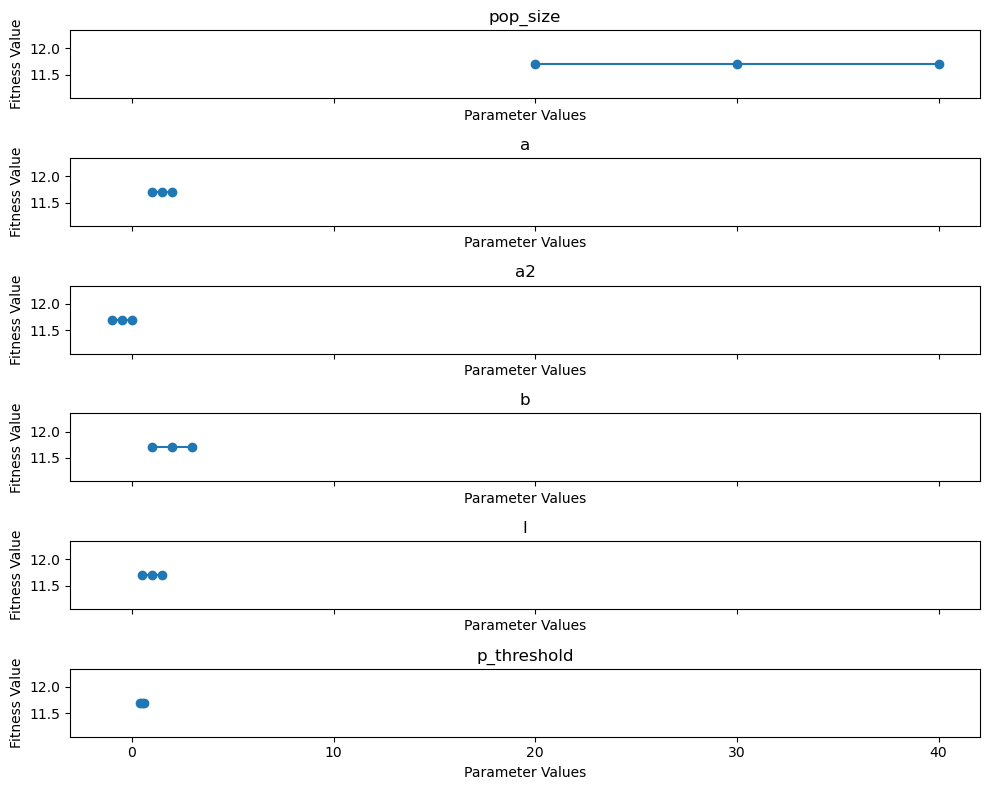

In [22]:
import matplotlib.pyplot as plt

# 定义参数网格中每个参数的名称和取值范围
param_names = ['pop_size', 'a', 'a2', 'b', 'l', 'p_threshold']
#param_values = [pop_size, a_values, a2_values, b_values, l_values, p_threshold]
param_values = [pop_sizes, a_values, a2_values, b_values, l_values, p_thresholds]
# 创建子图
fig, axes = plt.subplots(len(param_names), 1, figsize=(10, 8), sharex=True)

# 绘制每个参数的对比图
for i, (param_name, values) in enumerate(zip(param_names, param_values)):
    axes[i].plot(values, [best_fitness] * len(values), marker='o', linestyle='-')
    axes[i].set_title(param_name)
    axes[i].set_xlabel('Parameter Values')
    axes[i].set_ylabel('Fitness Value')

# 添加共享的 x 轴标签
plt.xlabel('Parameter Values')

# 调整子图布局
plt.tight_layout()

# 显示图形
plt.show()

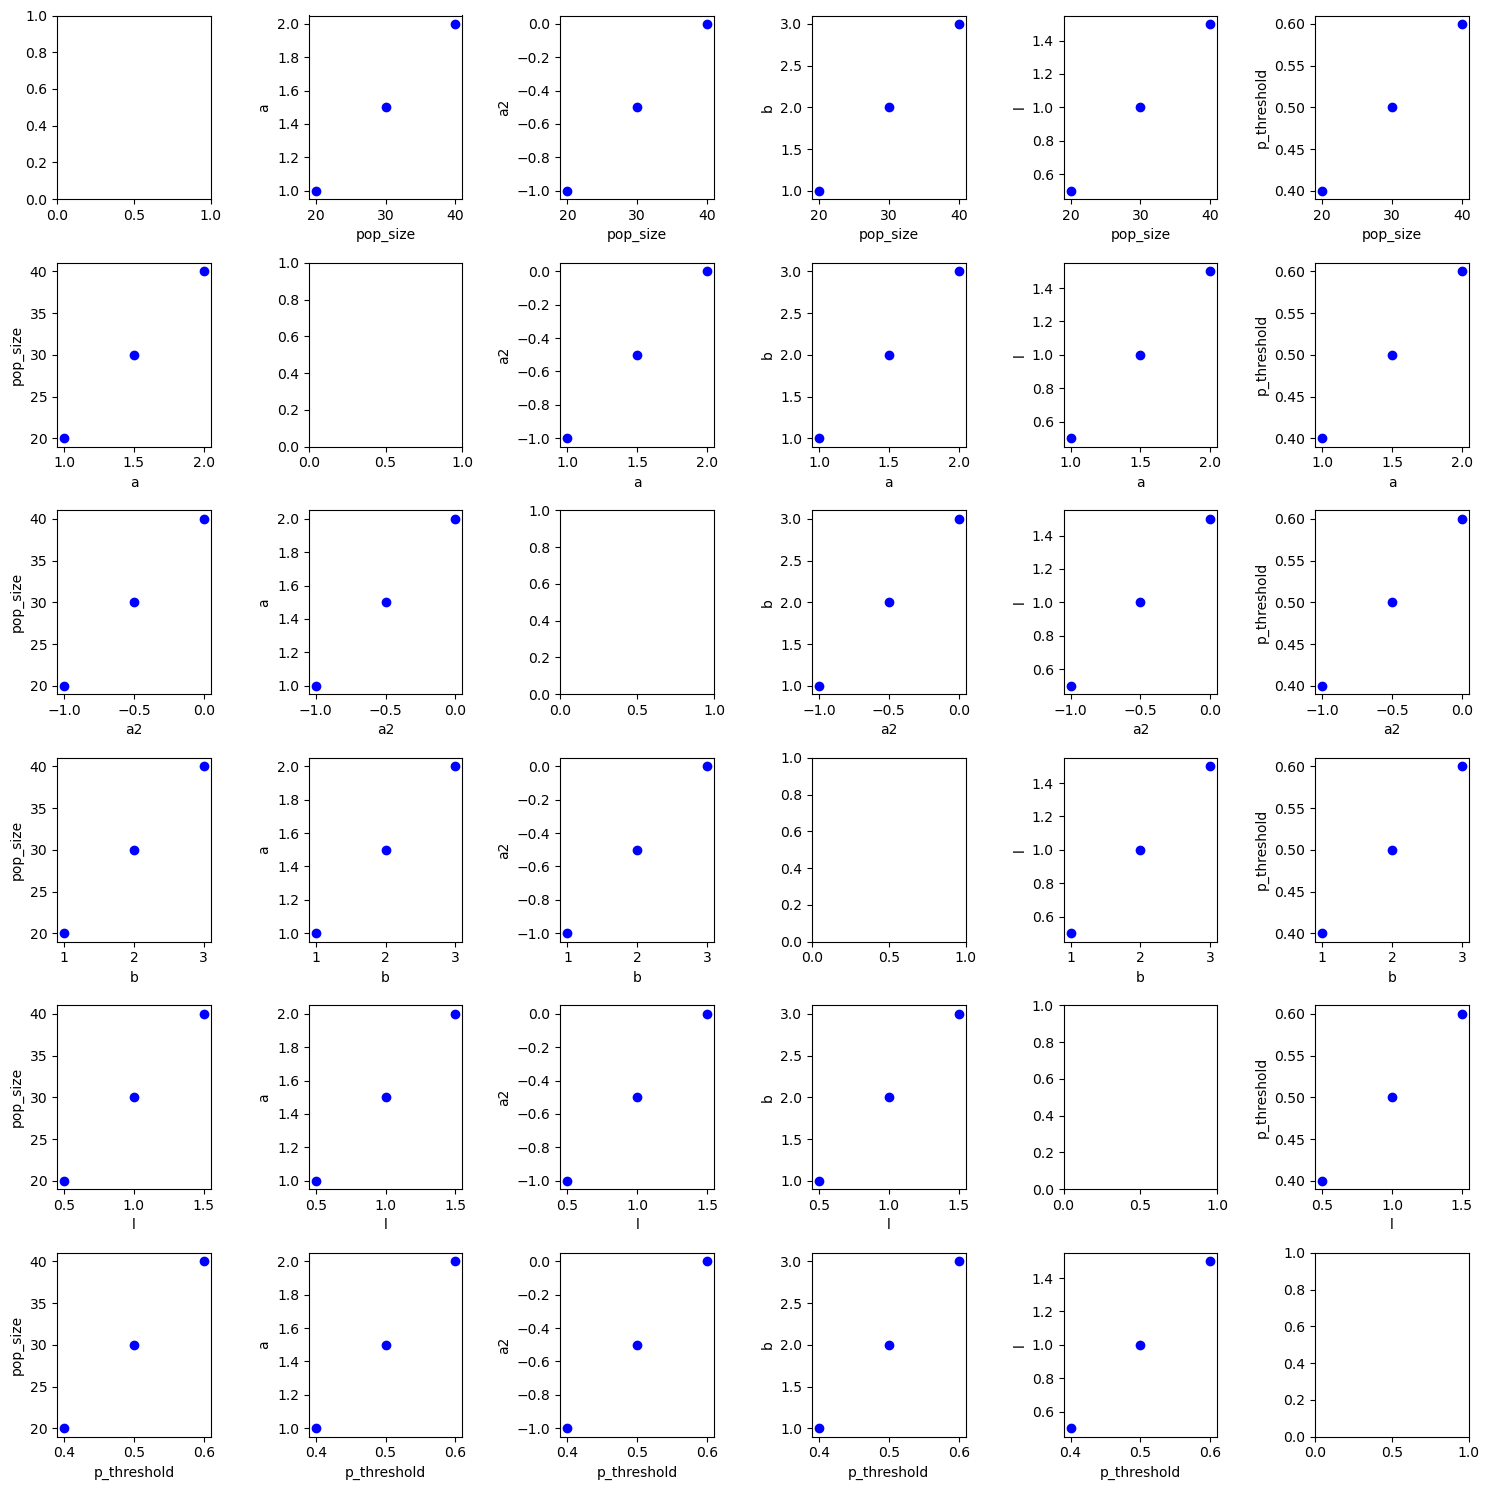

In [26]:
import matplotlib.pyplot as plt

# 创建子图网格
fig, axes = plt.subplots(len(param_names), len(param_names), figsize=(15, 15))

# 绘制每个参数之间的相关图形
for i, param1 in enumerate(param_names):
    for j, param2 in enumerate(param_names):
        if i != j:
            # 绘制 param1 和 param2 之间的相关图形
            axes[i, j].scatter(param_values[i], param_values[j], c='blue', marker='o')
            axes[i, j].set_xlabel(param1)
            axes[i, j].set_ylabel(param2)

# 调整子图布局
plt.tight_layout()

# 显示图形
plt.show()

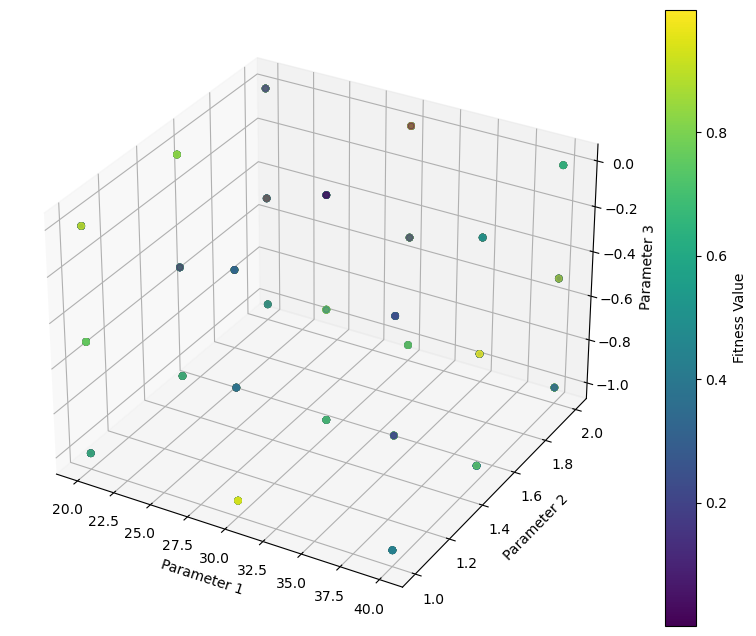

In [36]:
from mpl_toolkits.mplot3d import Axes3D

# 模拟获取每个参数组合对应的适应度值（这里用随机值代替）
best_fitness = np.random.rand(len(param_grid))

# 创建三维图形
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制三维图形
scatter = ax.scatter([params[0] for params in param_grid], 
                     [params[1] for params in param_grid], 
                     [params[2] for params in param_grid], 
                     c=best_fitness, 
                     cmap='viridis', 
                     marker='o')

# 设置轴标签
ax.set_xlabel('Parameter 1')
ax.set_ylabel('Parameter 2')
ax.set_zlabel('Parameter 3')

# 添加颜色条
cbar = plt.colorbar(scatter)
cbar.set_label('Fitness Value')

# 显示图形
plt.show()